<span style="font-size:larger; font-weight:bold; color:saturation(200%);">Ноутбук с основными этапами и находками в процессе решения соревнования</span>


In [1]:
import os
import sklearn.metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

In [2]:
%load_ext autoreload
%autoreload 2

In [44]:
import data
import visualization
import utils

# Data Preprocessing

Для начала заметим, что у части картинок не хватает в названии в таблицах уточнения формата фото. Восстановив формат, можно заметить, что у всех таких фотографий формат png. Визуализируем их.

All unique untyped formats are ['png']


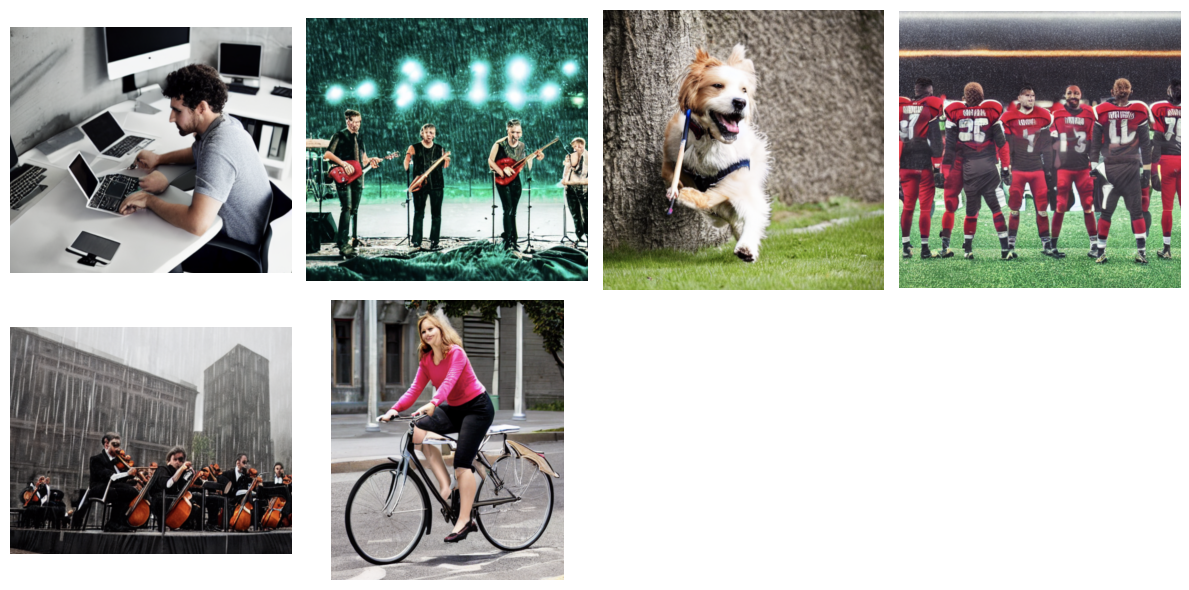

In [21]:
untyped_images, missed_types = data.get_untyped(csv_name="train.csv")
print("All unique untyped formats are", np.unique(missed_types))
visualization.visualise(file_names=untyped_images[:6])

Хм, выглядят подозрительно, давайте посмотрим распределение таргета в зависимости от формата фото

In [24]:
df = data.get_recovered(csv_name="train.csv")
df.groupby("format")["target"].mean(), df.groupby(["format"])["target"].count()

(format
 jpeg    1.0
 jpg     0.0
 png     1.0
 Name: target, dtype: float64,
 format
 jpeg    171
 jpg     667
 png     174
 Name: target, dtype: int64)

Окей, выяснили, что png в обучении всегда c таргетом 1. С jpeg и jpg все сложнее: вроде как тоже однозначно все понимаем, но т.к. это по сути один и тот же формат, то на инференсе могут возникнуть трудности. Давайте посмотрим на распределения по высоте и ширине среди jpeg и jpg:

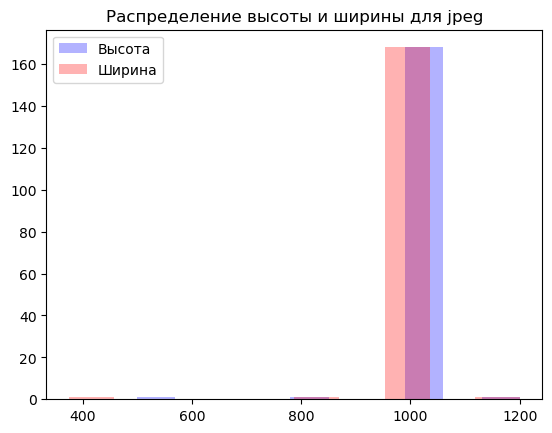

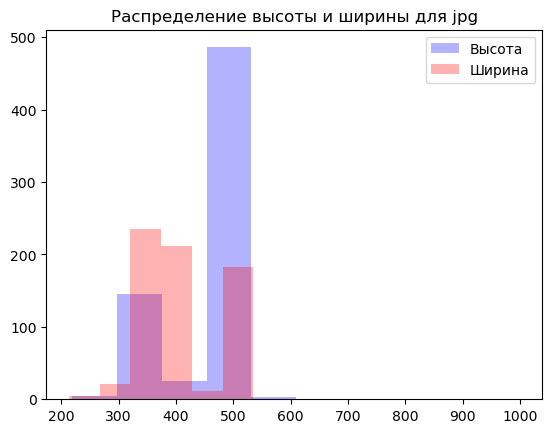

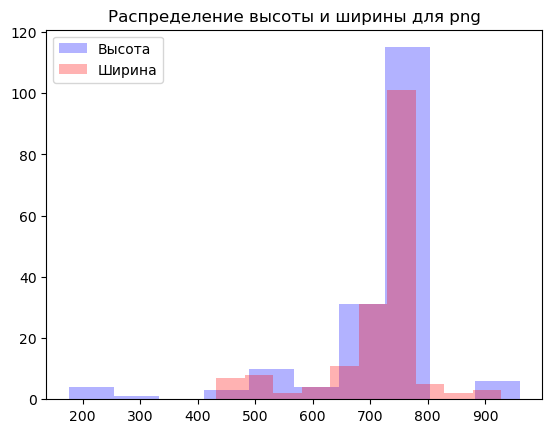

In [29]:
visualization.visualise_height_width_distr(df)

Что мы в итоге поняли: (1) у png таргет всегда 1 (2) у jpeg с размером 1024 на 1024 таргет всегда один. Но пока отложим эту информацию и отправимся обучать бейзлайн

# Training

Для начала начнем с базового предобученного Resnet50 и данные возьмем только те, которые были даны в соревновании. Здесь было два вопроса, на которые я пытался себе ответить: (1) нужны ли нам аугментации? (2) через сколько последних слоев прогонять градиент, а сколько первых оставить неизменными(не зря же модель преобучена на Imagenet)? Из моего опыта обычно обучают именно надстройку в конце, но как мы увидим, в детектировании сгенерированных фото все ровно наоборот.

1. Базовый Resnet50

На первых итерациях без аугментаций у меня особо ничего не получалось, так что давайте сразу с ними. Также заменил последний линейный слой resnet50 на 3 последовательных: 1024 - 512 - 2. 

In [ ]:
model = models.resnet50(pretrained=True)

for param in list(model.parameters())[:-2]:  #игрался с заморозкой: все не заморожены// последние 1//2 слоя не заморожены //                                                        
    param.requires_grad = False                     #только последний ботлнэк не заморожен // только линейный слой не заморожен

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(       #model.fc = nn.Linear(num_ftrs, 1)
    nn.Linear(num_ftrs, 1024), 
    nn.ReLU(inplace=True),     
    nn.Linear(1024, 512),       
    nn.ReLU(inplace=True),      
    nn.Linear(512, 2)          
)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()
train_dataloader, test_dataloader = data.get_train_test_dataloader(
    additional_train_data=[],
    included_formats=["png", "jpeg", "jpg"], 
    train_transforms=["crop", "flip", "rotation", "colorjitter", "gaussianblur"],
    batch_size=48,
    test_rate=0.2, 
    random_state=42,
)

In [ ]:
utils.train_model(
    model=model,
    optimizer=optimizer,
    loss_function=criterion,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    num_epochs=50,
    wandb_specs = {
        "project":"Kontur_Kaggle_Competition", 
        "name":f"resnet50_multiple_fc_example", 
        "config":{
        "lr": 1e-4,
        "architecture": "resnet50_multiple_fc_example",
        "dataset": "given",
        "epochs": 50
        }
    }
)

Ниже показаны результаты обучения из wandb:

<img src="utils/train_loss_basic_resnet50.png" alt="Image" height="300" width="450"> <img src="utils/val_loss_basic_resnet50.png" alt="Image" height="300" width="450">

Особый интерес у меня тут вызывала попытка с focal loss. Focal loss часто используется в задачах детектирования объектов на изображениях и обладает рядом преимуществ по сравнению с обычной кросс-энтропией, так как благодаря контролируемым гиперпараметрам можно контролировать, насколько нам важны объекты, которые мы и так умеем предсказывать(что позволяет не подгонять модель под то, что мы и так хорошо умеем отличать). Мне казалось это хорошей идеей, так как ну уж главное в начале суметь разделить, а потом теми же методами классического ml сможем сделать предсказанные вероятности более явными. Но, к сожалению, не зашло:( 

<div style="text-align:center;">
    <img src="utils/focal_loss.png" alt="Image" height="300" width="300">
</div>
    
Да и к тому же  так играться с этим во многом рискованно, так как всех моделей, которыми сгенерированы фото мы не знаем, а тогда на каком-то новом типе модели эти недостаточные зазоры в предиктах у модели, обученной на focal loss, могут оказаться существенными. **Если же еще сильнее углубиться в тематику, то во многих рисерчах по ai-детектированию стремятся именно увеличить зазор(например, "Online Detection of AI-Generated Images" by Adobe Research), а не делать на нем меньший упор.**

2. Улучшения базового Resnet50

Давайте пока не будем сразу пытаться добавлять новые данные, а попытаемся понять, как можно улучшить имеющуюся модель. Мне в голову пришло две идеи:

(1) генеративные модели выдают свои картинки из некоторого латентного пространства. В некоторых случаях это просто prior, или же еще может быть прослойка между приором и агрегированным постериорным, и эта прослойка достигается еще одной моделью, а уже потом оттуда мы прогоняем декодер, но не суть важно. В некоторых случаях, например, в задачах text2image, речь уже идет о постериорном распределении, которое выдается конкатенацией(с помощью модели) приора и эмбеддинга текста. Фишка в том, что модель генерирует картинку по данным, имеющимся в латентном пространстве: есть какие-то ключевые объекты и места между ними, где генерируется плавный переход от одного объекта к другому. Можно об этом еще думать, как о местах, где регионы очень насыщенные и в местах переходов текстура слабо различается. Это первый посыл, с которым можно думать об этом. **Тогда кажется, что и наш детектор должен обращать больше внимание на картинке больше на ключевые объекты, а фон должен быть не важен.**

(2) Другая идея, в некотором смысле противоположная первой, заключается на том подходе, которым руководствовался в далеком 2023 году студент Принстона, написавший весьма эффективный детектор ChatGPT-3.5. Модели производят слишком гладкие текста, которые не свойственны человеку. Как это перенести на язык computer vision? Распределение шума на сгенерированных картинках отличается от того, что мы наблюдаем на фото, сделанных камерой в естественной среде.

**Чтобы было надежнее проверять гипотезы и делать какие-то выводы мы будем двумя разными подходами**

2.1. Проверка гипотез

Окей, супер, есть ключевые объекты, которые должны содержать больше информации. Тогда давайте их детектить и обучать модель только на этих объектах, исключая неинтересные части картинки. А потом использовать их предикты все вместе и уже выдавать итоговый предикт по картинке. А так как на многих картинках в обучающей выборке содержатся люди, то детектить для простоты будем лица 


Возьмем для детектирования модель Retina Face, в обучающую выборку будем брать только фотки с размером не менее 32 на 32

<img src="utils/retina_face.png" alt="Image" height="300" width="900">

Модель представляет из себя классическую пирамидальную архитектуру, но имеется в работе ряд интересностей: 

(1) вместо классических сверток используются графовые(mesh decoder)

(2) использована сложная сумма лоссов и показано, как каждая компонента улучшает перформанс на WIDER FACE dataset

**(3) сделан акцент на уязвимости маленьких якорей(метод single-stage) к false positive, мне кажется, также отчасти актуально для нашей задачи** 

(4) в дополнение к классическому детектированию также предиктит позиции ключевых элементов лица, что позволяет воспроизводить 3d-картинку

In [81]:
import retina_face

retina_face.crop_faces("train.csv")

SyntaxError: invalid syntax (183684483.py, line 1)

Окей, кажется хорошо работает, но все-таки в итоговой своей модели я решил этот подход не использовать и повлиял на это по сути анализ, который приведен ниже

2.2. Проверка гипотез

Мне кажется, что у сверточных моделей-классификаторов вся фишка в извлечении семантического смысла за счет верхних слоев, а своим извлечением объектов мы как будто бы убиваем весь смысл. Такие методы более подходящи для методов, анализирующих корреляционные матрицы и какие-то геометрические формы!

Идея с равномерным выходом в целом понятно, почему не получилась: методы генерации в основном используют транспонированные свертки, а сверточные модели известны тем, что текстуру добавляют поэтапно(от более крупных к более мелким), а значит можно не сомневаться, что последние upconv добавляют уникальные элементы. Возможно, в будущем, в методах, где не будут использоваться свертки, этот подход возымеет успех

Окей, у нас ничего не получилось, но есть же более продвинутые и проверенные рисерчи по анализу шума в картинках, которые могут тут пригодиться. Действительно я встретил две очень интересные работы, одна из которых заключается в анализе геометрических форм сгенерированных фото("Shadows Don’t Lie and Lines Can’t Bend!" by U of Illinois), а другая в генерации случайных патчей и далее с помошью донейросетевых методов анализа фото генерации подобия некой корелляционной матрицы("PatchCraft: Exploring Texture Patch for Efficient AI-generated Image Detection" by Fudan University). 

Супер, в чем же проблема? **А проблема в том, что мы имеем дело в основном с сжатыми изображениями, где уровень сохраненного качества 69/79/80/96, что сразу же должно настрожить от использования этих более продвинутых методик**, которые очень свысока смотрят на детектирование простым резнетом. **Весь уникальный шум скорее всего был потерян во время сжатия, а попытки найти то, чего нет, не приведут ни к чему хорошему**, тем более в глубинном обучении, где не всегда ориентируются на статистические уровни значимости, а полагаются отчасти на имеющуюся экспертизу(речь именно непосредственно о построении модели, про a/b-тесты в продакте помним-помним)

3. Добавляем больше данных!

4. Adversarial attacks

In [ ]:
utils.get_attacked(model=model, dataloader=test_dataloader, attack_type="ifgsm")

In [ ]:
utils.get_attacked(model=model, dataloader=test_dataloader, attack_type="opt_uap")  #optimized universal attack

5. А вдруг придет VAE и все испортит???

Я думаю, что мы достаточно узнали о сгенерированных картинках, но насколько мы уверены в том, что реальные фото не были на самом деле сгенерированы? Ну, наверняка мы никогда не узнаем, но мы можем придать себе уверенности следующим: Возьмем сильный автокодировщик из библиотеки diffusers и посмотрим, как сгенерированная фотография будет отличаться от уже настоящей 

Давайте еще поглядим на популярное в последнее время добавление универсальных водяных знаков к картинке

Ну, выглядит так, что добавленный шум находится в самых очевидных местах, где он может находиться - в местах, где контекст сильно меняется. Если наша модель такое не способна детектить, то было бы совсем грустно, так что лично я в нее верю!

# Inference